In [1]:
import pandas_datareader as pdr
data = pdr.get_data_yahoo('NVDA')

In [2]:
#Convert to np array
import pandas as pd
import numpy as np

datanp = data.to_numpy()

In [4]:
def get_data_re(stock_data, no_days = 20):
    """
    Input 
    -----
    This function takes a n*x numpy array as input.
    n = number of days
    x = number of stock atrributes 
    
    Output
    -----
    A numpy array with x*10 + 1 cols. Each set of x cols contains stock data for a previous day.
    The last col contains a 1 if the stock has gone up since the previous and a 0 if it hasn't 
    
    """
    
    num_days = stock_data.shape[0] # variable containg number of days in stock data
    num_attr = stock_data.shape[1] # variable containg number of attributes per day 
    num_out_days = num_days - no_days # number of outputed days 
    
    output_data = np.zeros((num_out_days, 20 + 1))
    
    for i in range(no_days, num_days):
        
        samp_attr = stock_data[(i - no_days):i, 3] # get previous 20 days of stock data 
        
        samp_attr = samp_attr.flatten() # get all smaple observations in one row 
        
        samp_label = stock_data[i, 3]
        
        full_samp = np.append(samp_attr, samp_label) # combine attributes and label to get full sample
        
        output_data[i - no_days] = full_samp
        
    return output_data
        

In [4]:
regres_data = get_data_re(datanp)


In [5]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(regres_data[:, :60], regres_data[:, 60], random_state = 211)
print(X_train.shape, y_train.shape)

(928, 60) (928,)


In [6]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
mlp = MLPRegressor(random_state = 3, max_iter = 1000)
print('The generlaization accuracy is:', cross_val_score(mlp, X_train, y_train))
print(np.mean(cross_val_score(mlp, X_train, y_train)))

The generlaization accuracy is: [0.99363958 0.99433238 0.99314895 0.99215812 0.99435802]
0.993527410488156


In [7]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha' :  [0.0035, 0.0025, 0.0015], 'beta_1' : [0.981, 0.99, 0.999]  }

grid = GridSearchCV(mlp, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)

print("Best cross-validation accuracy:", grid.best_score_ )
print("Best parameters:", grid.best_params_ )

Best cross-validation accuracy: 0.9954416216021447
Best parameters: {'alpha': 0.0025, 'beta_1': 0.99}


In [8]:
# Test for reproducibility with test set
mlp = MLPRegressor(random_state = 3, alpha = 0.0025, beta_1 = 0.99, max_iter = 1000)
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)

0.9959626558094964

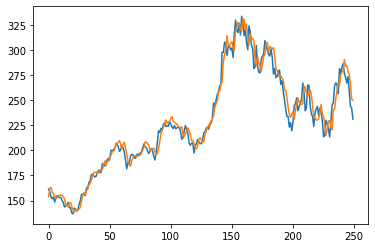

In [9]:
import matplotlib.pyplot as plt

last_270 = datanp[-270:] #last 270 days as +20 days of data needed for model
last_250_model_data = get_data_re(last_270) # get last 250 days of model data
last_250_X = last_250_model_data[:, :60] # get the unlabled data 
last_250_y = last_250_model_data[:, 60] # get the labels 
y_pred = mlp.predict(last_250_X) # get model predictions 

plt.plot(last_250_y)
plt.plot(y_pred)

In [10]:
np.sum(last_250_y - y_pred)

-383.1772524888878

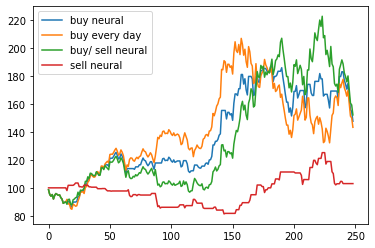

In [11]:
#Tends to underpredict increase in stock. So, if increase is seen good buy signal

money = 100
mon_change = np.zeros(249)

# using buy neral net stratergy 
for i in range(249):
    current_price = last_250_y[i]
    next_price = last_250_y[i + 1]
    current_data = last_250_X[i + 1]
    prediction = y_pred[i + 1]
    if prediction > current_price: # buy sig
        money = money * (next_price / current_price)
    mon_change[i] = money

money2 = 100    
mon_change2 = np.zeros(249)
# just simply buying and seling every day
for i in range(249):
    current_price = last_250_y[i]
    next_price = last_250_y[i + 1]
    money2 = money2 * (next_price  / current_price)
    mon_change2[i] = money2

money3 = 100
mon_change3 = np.zeros(249)
#using a buy sell strategy based on neural net 
for i in range(249):
    current_price = last_250_y[i]
    next_price = last_250_y[i + 1]
    current_data = last_250_X[i + 1]
    prediction = y_pred[i + 1]
    
    if prediction > current_price: # buy sig
        money3 = money3 * (next_price / current_price)
    else: #sell signal 
        money3 = money3 * (current_price / next_price)
        
    mon_change3[i] = money3

money4 = 100
mon_change4 = np.zeros(249)
#using a buy sell strategy based on neural net 
for i in range(249):
    current_price = last_250_y[i]
    next_price = last_250_y[i + 1]
    current_data = last_250_X[i + 1]
    prediction = y_pred[i + 1]
    
    if prediction < current_price: # sell sig
        money4 = money4 * (current_price / next_price)
        
    mon_change4[i] = money4

plt.plot(mon_change, label = 'buy neural')
plt.plot(mon_change2, label = 'buy every day')
plt.plot(mon_change3, label = 'buy/ sell neural')
plt.plot(mon_change4, label = 'sell neural')
plt.legend()

In [12]:
import copy
from sklearn.model_selection import KFold

def cross_conform_reg(X_train, y_train, mlp, e = 0.2):

    kf = KFold(shuffle = True, random_state = 211)
    all_non_conform = np.array([]) # empty array to store all non conformity scores 

    for rest_indx, fold_indx in kf.split(X_train):
        X_rest, X_fold = X_train[rest_indx], X_train[fold_indx] # fold is used as calibration set
        y_rest, y_fold = y_train[rest_indx], y_train[fold_indx]
        current_model = copy.deepcopy(mlp) # make a copy to prevent variable inheritance
        current_model.fit(X_rest, y_rest) # fit the current model with the data not in the current fold
        
        y_hat = current_model.predict(X_fold) # find the predictions for every sample 
        current_nonconform = np.absolute(y_fold - y_hat)  # calculate non conformity scores 
        all_non_conform = np.append(all_non_conform, current_nonconform) #append current non conform scores to all
    
    non_conform = np.sort(all_non_conform) # sort the non confromity scores in accending order 

    k = int((1 - e) * (non_conform.size + 1)) # calculate the non-confimity index for given e 
    c = non_conform[k] # obtain the non-conformity score which satisfies e (-1 as python indexs from o)
    
    return c
    



In [13]:
mlp = MLPRegressor(random_state = 3, alpha = 0.0025, beta_1 = 0.99, max_iter = 1000)
c = cross_conform_reg(X_train, y_train, mlp, e = 0.2)
c

4.499302721762298

Find the test error rate of the indiuctive conformal predictor 

In [29]:
def cross_conform_error(X_test, y_test, c, mlp):
    y_hat = mlp.predict(X_test) # get predicted y values
    error = np.zeros(y_test.size)
    
    for i in range(y_test.size):
        current_prediction = y_hat[i]
        lower_bound = current_prediction - c
        upper_bound = current_prediction + c
        
        if y_test[i] < lower_bound or y_test[i] > upper_bound:
            error[i] = 1 
    
    error_rate = np.sum(error) / y_test.size
    
    return error_rate 
        

In [30]:
mlp = MLPRegressor(random_state = 3, alpha = 0.0025, beta_1 = 0.99, max_iter = 1000)
mlp.fit(X_train, y_train)
print(cross_conform_error(X_test, y_test, c, mlp))

0.1967741935483871


The test error rate is close yo the 0.2 level suggesting that the prediction set is valid.

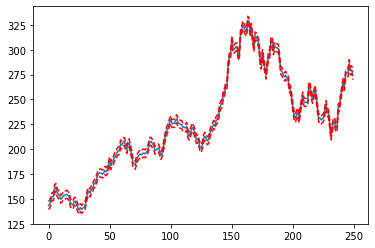

In [31]:
# plot this prediction interval with the last 250 days of stock data
lower_pred = y_pred - c
upper_pred = y_pred + c

plt.plot(y_pred)
plt.plot(lower_pred, linestyle = '--', color = 'red')
plt.plot(upper_pred, linestyle = '--', color = 'red')

Now, i will try a new buy sell stratergy. If the prediction is a increase higher than c than there is a very good chance that the stock will go up.As, the lower bound is at or below the current price. Therefore, this can be taken as a buy signal. In a similar way a decrease lower than c can be interpreted as a sell signal. 

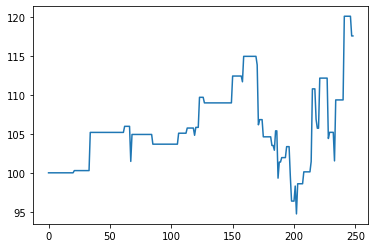

In [32]:
# using buy neral net stratergy 
money = 100
mon_change = np.zeros(249)
mon_change[0] = money

for i in range(249):
    current_price = last_250_y[i]
    next_price = last_250_y[i + 1]
    prediction = y_pred[i + 1]
    if prediction > current_price + c: # buy sig
        money = money * (next_price / current_price)
    elif current_price < prediction - c: # sell sig
        money = money * (next_price / current_price)
    
    mon_change[i] = money

plt.plot(mon_change)


Now, I will experiment performance with different error rates. 

In [36]:
def error_perform(actual_prices, predicted_prices, c):
    """
    Input
    -------
    actual_prices: A n by 1 numpy array containg the real prices of a particular stock.
    predicted_prices: A n by 1 numpy array containg the prices predicted by a model of particular stock.
    c: A numpy array conting a prediction boundary for each error rate
    
    Output
    -------
    Net_gain: Net gain over 100 pounds invested using a trading stratergy based off model predictions and confromal prediction 
    interval
    Total_loses: Total daily loses over a n - 1 day period.
    """
    
    num_er = c.size # number of error rates being tested
    days_tested = actual_prices.size - 1 # number of days being tested 
    Net_gain = np.zeros(num_er) 
    Total_loses = np.zeros(num_er)
    
    for i in range(num_er):
        current_c = c[i]
        money = 100
        mon_change = np.zeros(days_tested) # change in money invested for each day
        loses = np.zeros(days_tested) # daily loses 
        
        for j in range(days_tested):
            current_price = actual_prices[j]
            next_price = actual_prices[j + 1]
            prediction = predicted_prices[j + 1]
            
            if prediction > current_price + current_c: # buy sig
                money = money * (next_price / current_price)
            elif current_price < prediction - current_c: # sell sig
                money = money[j] * (next_price / current_price)
            
            mon_change[j] = money # record money for the day
            
            if mon_change[j] < mon_change[j - 1]: # if there is a loss
                loses[j] = mon_change[j] - mon_change[j - 1]
            
        Net_gain[i] = mon_change[-1] - 100 # store net gain and total loses for error rate
        Total_loses[i] = np.sum(loses)
    
    return Net_gain, Total_loses

In [44]:
error_rates = np.arange(0.01, 1, 0.01)
prediction_boundary = np.zeros(error_rates.size)

for i in range(error_rates.size): # calculate prediction sets
    mlp = MLPRegressor(random_state = 3, alpha = 0.0025, beta_1 = 0.99, max_iter = 1000)
    prediction_boundary[i] = cross_conform_reg(X_train, y_train, mlp, e = error_rates[i])
    print('Itertation', i)



Itertation 0
Itertation 1
Itertation 2
Itertation 3
Itertation 4
Itertation 5
Itertation 6
Itertation 7
Itertation 8
Itertation 9
Itertation 10
Itertation 11
Itertation 12
Itertation 13
Itertation 14
Itertation 15
Itertation 16
Itertation 17
Itertation 18
Itertation 19
Itertation 20
Itertation 21
Itertation 22
Itertation 23
Itertation 24
Itertation 25
Itertation 26
Itertation 27
Itertation 28
Itertation 29
Itertation 30
Itertation 31
Itertation 32
Itertation 33
Itertation 34
Itertation 35
Itertation 36
Itertation 37
Itertation 38
Itertation 39
Itertation 40
Itertation 41
Itertation 42
Itertation 43
Itertation 44
Itertation 45
Itertation 46
Itertation 47
Itertation 48
Itertation 49
Itertation 50
Itertation 51
Itertation 52
Itertation 53
Itertation 54
Itertation 55
Itertation 56
Itertation 57
Itertation 58
Itertation 59
Itertation 60
Itertation 61
Itertation 62
Itertation 63
Itertation 64
Itertation 65
Itertation 66
Itertation 67
Itertation 68
Itertation 69
Itertation 70
Itertation 71
It

In [37]:
prediction_boundary

array([1.01714835e-03, 1.34268513e+00, 4.01801101e+00, 6.39539984e+00,
       9.94456078e+00, 2.13132420e+01])

In [45]:
gain, loses = error_perform(last_250_y, y_pred, prediction_boundary)

In [41]:
gain

array([63.39659107, 10.60777877, 17.55478603, 12.30459292,  8.47501173,
        0.        ])

In [42]:
loses

array([-226.20520091, -123.1356937 ,  -56.44916049,  -34.3071477 ,
          0.        ,    0.        ])

Text(0, 0.5, 'Money in £')

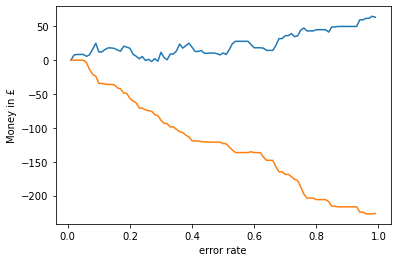

In [46]:
plt.plot(error_rates, gain, label = 'Net gain')
plt.plot(error_rates, loses, label = 'Total_loses')
plt.legend
plt.xlabel('error rate')
plt.ylabel('Money in £')

Text(0, 0.5, 'Money in £')

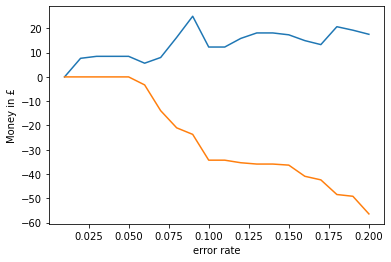

In [47]:
plt.plot(error_rates[0:20], gain[0:20], label = 'Net gain')
plt.plot(error_rates[0:20], loses[0:20], label = 'Total_loses')
plt.legend
plt.xlabel('error rate')
plt.ylabel('Money in £')

In [26]:
import numpy as np
import copy
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt


class cross_confrom_regress():
    
    
    def __init__(self, X_train, y_train, model):
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.fitted_model = model.fit(X_train, y_train)
        
        
    def get_prediction_interval(self, e, get_test_error = False, X_test = None, y_test = None):
        
        """
        This function gives the prediction interval for a particular error rate e. The validity of that particular interval
        can be checked by using the the interval test error rate. To do this set get_test_error = True.
        """
        X_train = self.X_train # get object attributes 
        y_train = self.y_train
        model = self.model
        
        kf = KFold(shuffle = True, random_state = 211)
        all_non_conform = np.array([]) # empty array to store all non conformity scores 

        for rest_indx, fold_indx in kf.split(X_train):
            X_rest, X_fold = X_train[rest_indx], X_train[fold_indx] # fold is used as calibration set
            y_rest, y_fold = y_train[rest_indx], y_train[fold_indx]
            current_model = copy.deepcopy(model) # make a copy to prevent variable inheritance
            current_model.fit(X_rest, y_rest) # fit the current model with the data not in the current fold
        
            y_hat = current_model.predict(X_fold) # find the predictions for every sample 
            current_nonconform = np.absolute(y_fold - y_hat)  # calculate non conformity scores 
            all_non_conform = np.append(all_non_conform, current_nonconform) #append current non conform scores to all
    
        non_conform = np.sort(all_non_conform) # sort the non confromity scores in accending order 

        k = int((1 - e) * (non_conform.size + 1)) # calculate the non-confimity index for given e 
        c = non_conform[k] # obtain the non-conformity score which satisfies e (-1 as python indexs from o)
        
        prediction_interval = c # set c as the prediction interval
        
        if get_test_error == True:
            
            fitted_model = self.fitted_model
            current_model = copy.deepcopy(fitted_model) # get a copy of the fitted model
            y_hat = current_model.predict(X_test) # get predicted y values for the test set 
            error = np.zeros(y_test.size) # create an empty 
    
            for i in range(y_test.size):
                current_prediction = y_hat[i] # get the current y_hat
                lower_bound = current_prediction - c # get the upper and lower bounds of the curent y hat
                upper_bound = current_prediction + c
        
                if y_test[i] < lower_bound or y_test[i] > upper_bound: # if out of prediction interval 
                    error[i] = 1 # set error to 1 if there an error on current y_hat
    
                error_rate = np.mean(error) # get the mean of the error rates 
        
        else:
            error_rate = None
            
        return prediction_interval, error_rate
    
    
        def get_calibration_curve(self, X_test, y_test, get_inter = False):
            
            """
            This function produces a calibration curve to check the validitiy of the confornal predictor. Also, if 
            get_inter = True, then the intervals for error rates between 0.01 and 1 with step 0.01 may be obtained. 
            """
            
            error_rates = np.arange(0.01, 1, 0.01) # get error rates in range 0.01 to 1 with step 0.01
            test_error_rates = np.zeros(error_rates.size)
            all_inter = np.zeros(error_rates.size)
            
            for i in range(error_rate.size):
                # use previous function to get test error rate for current error rate in loop
                predict_inter, t_error_rate = get_prediction_interval(error_rate[i], True, X_test, y_test)
                test_error_rates[i] = t_error_rate
                all_inter[i] = predict_inter
            
            plt.plot(error_rates, test_error_rates) # plot the calibration curve 
            plt.xlabel('error rate')
            plt.ylabel('test error rate')
            plt.title('Calibration curve')
            plt.show()
            
            if get_inter == False:
                all_inter = None
            
            return all_inter
        

In [27]:
mlp = MLPRegressor(random_state = 3, alpha = 0.0025, beta_1 = 0.99, max_iter = 1000)
cross_stock = cross_confrom_regress(X_train, y_train, mlp)
pred_inter = cross_stock.get_prediction_interval(0.05, True, X_test, y_test)
print(pred_inter)

(12.256428108431209, 0.041935483870967745)
